In [36]:
import pandas as pd
import seaborn as sns
from pandas import Timedelta
import warnings
import itertools
from scipy.sparse import csr_matrix, vstack, hstack
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme()
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
sessions = pd.read_json("data/sessions.jsonl", lines=True)
artists = pd.read_json("data/artists.jsonl", lines=True)
tracks = pd.read_json("data/tracks.jsonl", lines=True)
track_storage = pd.read_json("data/track_storage.jsonl", lines=True)
users = pd.read_json("data/users.jsonl", lines=True)
genres = tracks.join(artists.set_index('id')['genres'], on='id_artist', rsuffix='_author').set_index('id')['genres']
all_genres = genres.explode().unique()


def genre_similarity(g1, g2):
    g1_words = set(g1.lower().split())
    g2_words = set(g2.lower().split())
    return len(g1_words.intersection(g2_words))/(len(g1_words.union(g2_words)))

def genres_similarity(genres1, genres2):
    simillarity = 0
    for g1, g2 in itertools.product(genres1, genres2):
        indicator = 2
        if g1 != g2:
            words_genre1 = set(g1.lower().split())
            words_genre2 = set(g2.lower().split())
            indicator = 1 if any(word in words_genre2 for word in words_genre1) else 0
        simillarity += indicator
    return simillarity

def extract_release_date(tdf: pd.DataFrame):
    def standardize_date(date):
        parts = date.split('-')
        if len(parts) == 1:  # Only year
            return f"{parts[0]}-01-01"
        elif len(parts) == 2:  # Year and month
            return f"{parts[0]}-{parts[1]}-01"
        return date
    
    def date_completeness(date):
        parts = len(date.split('-'))
        if parts == 1:
            return 'year'
        elif parts == 2:
            return 'year_month'
        return 'full_date'
    
    tdf['standardized_date'] = pd.to_datetime(tdf['release_date'].apply(standardize_date))
    tdf['release_year'] = tdf['standardized_date'].dt.year
    tdf['release_daymonth'] = tdf['standardized_date'].dt.dayofyear
    tdf['date_completeness'] = tdf['release_date'].apply(date_completeness)

    return tdf.drop(columns=['standardized_date'])

def show_basic_info(df: pd.DataFrame):
    print("# rows", len(df))
    print("Columns", df.columns.values)
    print("Missing values: ", df.columns[(df.isna().mean()>0) | (df.isnull().mean()>0) ])

def encode_track(track_genres):
    row_indices, col_indices, data = [], [], []
    for i, track_genre in enumerate(track_genres):
        for j, other_genre in enumerate(all_genres):
            similarity = genre_similarity(track_genre, other_genre)
            if similarity != 0:
                row_indices.append(i)
                col_indices.append(j)
                data.append(similarity)
    return csr_matrix(csr_matrix((data, (row_indices, col_indices)), shape=(len(track_genres), len(all_genres))).sum(axis=0))

def clear_tracks(df: pd.DataFrame):
    df=df.drop(columns=['mode'])
    df = extract_release_date(df).drop(columns=['release_date'])
    return df

clean_track = clear_tracks(tracks)
X = clean_track.loc[:, 'danceability':'time_signature'].values
pca = PCA(n_components=2)
principal_components = pca.fit_transform(StandardScaler().fit_transform(X))
pca_df = pd.DataFrame(data=principal_components, columns=['MUSIC1', 'MUSIC2'], index=clean_track.index)
clean_track = pd.concat([clean_track[['id', 'popularity', 'id_artist', 'release_year', 'release_daymonth', 'date_completeness', 'duration_ms']], pca_df], axis=1).set_index('id')

In [232]:
max(tracks['duration_ms'])

4027622

In [69]:
# block is group of consecutive user interactions with song
def transform_block(df: pd.DataFrame):
    
    def define_block_duration(group: pd.DataFrame):
        if 'skip' not in group['event_type'].values:
            return pd.Timedelta(milliseconds=min(group['duration_ms']))
        return max(group['timestamp'])-min(group['timestamp'])
    return df.groupby('block_id').agg(
        isskipped=('event_type', lambda x: 'skip' in x.values),
        isliked=('event_type', lambda x: 'like' in x.values),
        timestamp=('timestamp', lambda x: min(x)),
        track_id=('track_id', 'first'),
        user_id=('user_id', 'first'),
        block_duration = ('timestamp', lambda x: define_block_duration(df)),
        song_listened = ('timestamp', lambda x: define_block_duration(df).total_seconds()*1000/min(df['duration_ms']))
    ).reset_index(drop=True)

def transform_session(session: pd.DataFrame):
    session['block_id'] = (session['track_id'] != session['track_id'].shift()).cumsum()
    session = session.groupby('block_id').apply(transform_block).reset_index(drop=True)
    session['previous_song_listened']=session['song_listened'].shift(fill_value=1.0)
    session['song_listened_rate']=session['previous_song_listened'].ewm(alpha=0.8).mean()

    session['session_duration'] = session['block_duration'].cumsum().shift(fill_value=Timedelta(0))
    session['session_skip_count'] = session['isskipped'].cumsum().shift(fill_value=0)
    session['session_like_count'] = session['isliked'].cumsum().shift(fill_value=0)
    session['session_play_count'] = range(len(session))
    
    session['session_skip_rate'] = (session['session_skip_count'] / session['session_play_count']).fillna(0)
    session.replace(np.inf, 0, inplace=True)
    
    session['session_ewma_rate'] = session['isskipped'].astype(int).ewm(alpha=0.8).mean().shift(fill_value=0)
    
    session['previous_action']=session['isskipped'].shift(fill_value=0)
    return session

def transform_user(user: pd.DataFrame):
    user['user_listen_time'] = user['block_duration'].cumsum().shift(fill_value=Timedelta(0))
    user['user_skip_count'] = user['isskipped'].cumsum().shift(fill_value=0)
    user['user_like_count'] = user['isliked'].cumsum().shift(fill_value=0)
    user['user_play_count'] = range(len(user))
    user['user_skip_rate'] = (user['user_skip_count'] / user['user_play_count']).fillna(0)
    user.replace(np.inf, 0, inplace=True)
    user['user_ewma_rate'] = user['isskipped'].astype(int).ewm(alpha=0.8).mean().shift(fill_value=0)
    user['user_listened_rate']=user['previous_song_listened'].ewm(alpha=0.8).mean()
    return user

def preprocess_dataset(df: pd.DataFrame):
    final_dataset = df.dropna()
    label_encoder = LabelEncoder()
    final_dataset['city'] = label_encoder.fit_transform(final_dataset['city'])
    final_dataset['user'] = label_encoder.fit_transform(final_dataset['user'])
    
    final_dataset['day']=final_dataset['timestamp'].dt.dayofyear
    final_dataset['hourminute']= final_dataset['timestamp'].dt.hour * 60 + final_dataset['timestamp'].dt.minute
    final_dataset['date_completeness'] = label_encoder.fit_transform(final_dataset['date_completeness'])
    # IMPORTANT DROP FOR LEAKAGE
    final_dataset = final_dataset.drop(columns=['block_duration', 'song_listened'])
    
    final_dataset['session_duration']=final_dataset['session_duration'].apply(lambda x: x.total_seconds())
    final_dataset['user_listen_time']=final_dataset['user_listen_time'].apply(lambda x: x.total_seconds())
    
    final_dataset['premium_user']=final_dataset['premium_user'].astype(int)
    final_dataset['isliked']=final_dataset['isliked'].astype(int)
    final_dataset['isskipped']=final_dataset['isskipped'].astype(int)
    final_dataset['previous_action']=final_dataset['previous_action'].astype(int)
    
    # numeric_cols = final_dataset.select_dtypes(include=['float64']).columns
    # scaler = StandardScaler()
    # final_dataset[numeric_cols] = scaler.fit_transform(final_dataset[numeric_cols])
    
    return final_dataset.drop(columns=['timestamp', 'street', 'name', 'favourite_genres', 'genres'])

In [73]:
df = sessions[sessions['event_type'].isin(['play', 'skip', 'like'])]
df = df.merge(clean_track[['duration_ms']], left_on="track_id", right_on='id')
df = df.groupby('session_id').apply(transform_session).reset_index().drop(columns=['level_1'])
df = df.groupby('user_id').apply(transform_user).reset_index(drop=True)
df = df.join(users.set_index('user_id'), on='user_id', rsuffix="_user").join(genres, on="track_id").join(clean_track, on="track_id", rsuffix="_track")
df['fav_genres_similarity'] = df.apply(lambda x: genres_similarity(x['genres'], x['favourite_genres']), axis=1)
df.to_csv("data/result.csv")
df['user']=df['user_id']
target_df=df.drop(columns=[col for col in df.columns if 'id' in col])
final_dataset = preprocess_dataset(target_df)
final_dataset

,isskipped,isliked,previous_song_listened,song_listened_rate,session_duration,session_skip_count,session_like_count,session_play_count,session_skip_rate,session_ewma_rate,...,release_year,release_daymonth,date_completeness,duration_ms,MUSIC1,MUSIC2,fav_genres_similarity,user,day,hourminute
0,0,1,1.000000,1.000000,0.000,0,0,0,0.000000,0.000000,...,1981,238,0,437813,0.786554,-0.854327,12,0,2,358
1,0,1,1.000000,1.000000,437.813,0,1,1,0.000000,0.000000,...,1980,1,0,117107,1.445086,0.211086,12,0,2,366
2,0,1,1.000000,1.000000,554.920,0,2,2,0.000000,0.000000,...,1998,1,0,224933,0.561619,-1.390110,8,0,2,368
3,0,1,1.000000,1.000000,779.853,0,3,3,0.000000,0.000000,...,1970,152,0,373970,0.409086,-2.071424,12,0,2,371
4,1,0,1.000000,1.000000,1153.823,0,4,4,0.000000,0.000000,...,1979,32,2,224000,-1.423538,-0.515780,22,0,2,377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12359,1,0,1.000000,0.971852,9783.485,20,0,28,0.714286,0.040000,...,2017,209,0,209640,-0.625339,2.962431,0,49,301,1299
12360,1,0,0.104713,0.278141,9805.437,21,0,29,0.724138,0.808000,...,2021,43,0,194827,-1.035433,1.043415,0,49,301,1251
12361,1,0,0.588902,0.526750,9920.171,22,0,30,0.733333,0.961600,...,2020,177,0,261603,-0.528758,0.672207,0,49,301,1338
12362,1,0,0.728604,0.688233,10110.776,23,0,31,0.741935,0.992320,...,2021,78,0,235665,2.748376,-0.300488,0,49,301,1248


Inertia: 6.574648135456066
Silhouette Score: 0.6077581167042606
Calinski-Harabasz Index: 101.83789934224164
Davies-Bouldin Index: 0.48205234504695244


,user_skip_rate,user_listened_rate,cluster
user,,,
0,0.114540,0.963158,0
1,0.139737,0.889242,0
2,0.437955,0.784426,1
3,0.823360,0.614603,3
4,0.280121,1.135292,5
5,0.877807,1.361261,4
6,0.438669,0.913803,1
7,0.261248,0.949178,0
8,0.341320,1.178627,5


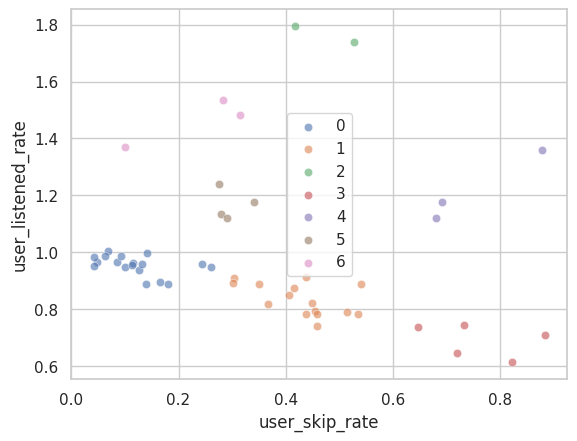

In [165]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

col1 = 'user_skip_rate'
col2 = 'user_listened_rate'
df=final_dataset[final_dataset['isskipped']==1].groupby('user')[[col1, col2]].agg(['mean'])
best_k=4
indc = -1000
k_range = range(2, 10)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
for k in k_range:
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit_predict(df_scaled)
    silhouette = silhouette_score(df_scaled, kmeans.labels_)
    if silhouette > indc:
        best_k = k
        indc = silhouette
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
kmeans = KMeans(n_clusters=best_k)  # Choose the number of clusters (n_clusters) based on your needs
clusters = kmeans.fit_predict(df_scaled)
df['cluster']=clusters

# Assuming you have your data 'X' and your KMeans model 'kmeans'

# Inertia
inertia = kmeans.inertia_

# Silhouette Score
silhouette = silhouette_score(df_scaled, kmeans.labels_)

# Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(df_scaled, kmeans.labels_)

# Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(df_scaled, kmeans.labels_)

print("Inertia:", inertia)
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)
df.columns=df.columns.droplevel(1)
for i in range(best_k):
    sns.scatterplot(df[df['cluster']==i], x=col1, y=col2, label=i, alpha=0.6)
df

In [167]:
final_dataset=final_dataset.join(df[['cluster']], on='user').drop(columns=['user'])

In [184]:
final_dataset[final_dataset['session_play_count']>2]

,isskipped,isliked,previous_song_listened,song_listened_rate,session_duration,session_skip_count,session_like_count,session_play_count,session_skip_rate,session_ewma_rate,...,release_year,release_daymonth,date_completeness,duration_ms,MUSIC1,MUSIC2,fav_genres_similarity,day,hourminute,cluster
3,0,1,1.000000,1.000000,779.853,0,3,3,0.000000,0.000000,...,1970,152,0,373970,0.409086,-2.071424,12,2,371,0
4,1,0,1.000000,1.000000,1153.823,0,4,4,0.000000,0.000000,...,1979,32,2,224000,-1.423538,-0.515780,22,2,377,0
5,0,1,0.409772,0.527788,1245.612,1,4,5,0.200000,0.800256,...,1981,126,0,185271,-2.101553,-1.436643,8,2,379,0
6,0,1,1.000000,0.905562,1430.883,1,5,6,0.166667,0.160010,...,1981,305,0,230867,-0.470488,0.960793,14,2,382,0
7,0,1,1.000000,0.981113,1661.750,1,6,7,0.142857,0.032000,...,1995,1,0,150333,-0.806550,0.409402,6,2,386,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12359,1,0,1.000000,0.971852,9783.485,20,0,28,0.714286,0.040000,...,2017,209,0,209640,-0.625339,2.962431,0,301,1299,4
12360,1,0,0.104713,0.278141,9805.437,21,0,29,0.724138,0.808000,...,2021,43,0,194827,-1.035433,1.043415,0,301,1251,4
12361,1,0,0.588902,0.526750,9920.171,22,0,30,0.733333,0.961600,...,2020,177,0,261603,-0.528758,0.672207,0,301,1338,4
12362,1,0,0.728604,0.688233,10110.776,23,0,31,0.741935,0.992320,...,2021,78,0,235665,2.748376,-0.300488,0,301,1248,4


In [226]:
final_dataset['age']=2023-final_dataset['release_year']

Accuracy: 0.7288409703504043
Precision: 0.6243432574430823
Recall: 0.5527131782945737
F1 Score: 0.5863486842105263
ROC-AUC: 0.6877202255109232


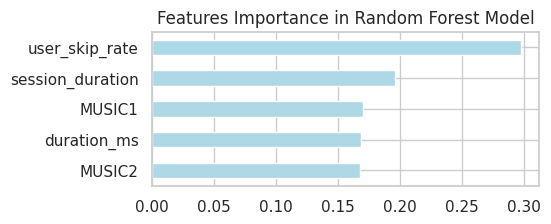

In [229]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# final_dataset = preprocess_dataset(target_df)
fdf = final_dataset
Y = fdf['isskipped']
# X = fdf.drop(columns=['isskipped'])
X = fdf[['user_skip_rate', 'MUSIC1', 'MUSIC2', 'session_duration', 'duration_ms']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

clf = RandomForestClassifier(n_estimators=100, class_weight={0: 10, 1: 1})
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Print metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
# ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot()

feature_importances = clf.feature_importances_
feature_names = X.columns
importances = pd.Series(feature_importances, index=feature_names)
importances_sorted = importances.sort_values()
plt.figure(figsize=(5,2))
importances_sorted.plot(kind='barh', color='lightblue')
plt.title('Features Importance in Random Forest Model')
plt.show()